In [30]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [31]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [32]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## We want to know what % of 1.5 NOVEL sjs that we 1. discover only in personal haplotypes that have variants (+- 10 of splice junctions OR in splice sites) OR noncanonical hg38 splice motifs

In [33]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

In [34]:
# 1.5 only novel sjs
temp = df.loc[df.junction_novelty=='novel']

In [35]:
# get only the detection from mapping
temp = temp[['sj_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['sj_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

In [36]:
# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

In [37]:
# 2. get the hg38 canonicity of each of these sjs
temp2 = df[['sj_id', 'splice_motif', 'canonical', 'sqanti_genome']].drop_duplicates()
temp2 = temp2.loc[temp2.sqanti_genome=='hg38']
assert len(temp2.loc[temp2.sj_id.duplicated()]) == 0
temp = temp.merge(temp2, how='left', 
                  on='sj_id')

In [38]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['sj_12nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df
    df = df.drop_duplicates()
    
    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    df = df[['sj_id']]
    
    df['cell_line_id'] = c
    df['exon_12nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)
sj_snp_df.head()

,sj_id,cell_line_id,exon_12nt_has_var
0,chr1_+_100133316_100136881,HG04217,True
1,chr1_+_101371522_101389669,HG04217,True
2,chr1_+_101371524_101377257,HG04217,True
3,chr1_+_101371524_101383321,HG04217,True
4,chr1_+_101371524_101383417,HG04217,True


In [39]:
temp = temp.merge(sj_snp_df[['sj_id', 'cell_line_id', 'exon_12nt_has_var']],
                  how='left',
                  on=['sj_id', 'cell_line_id'])
temp.exon_12nt_has_var.fillna(False, inplace=True)

In [40]:
temp['has_explanation'] = (temp.canonical=='non_canonical')|\
                          (temp.exon_12nt_has_var==True)
temp.head()

,sj_id,cell_line_id,hap1,hap2,hg38,splice_motif,canonical,sqanti_genome,exon_12nt_has_var,has_explanation
0,GL000194.1_-_53893_55445,HG03729,False,True,False,GTAG,canonical,hg38,False,False
1,GL000194.1_-_53893_55445,HG04217,False,True,False,GTAG,canonical,hg38,False,False
2,GL000194.1_-_54956_55445,HG04217,False,True,False,GTAG,canonical,hg38,False,False
3,KI270726.1_+_26127_26229,HG02261,True,False,False,GTAG,canonical,hg38,False,False
4,chr10_+_100987611_100989643,NA19307,True,True,False,GTAG,canonical,hg38,True,True


In [41]:
# compute the # and % of hap1/hap2-spec sjs (per sample) that are canonical
# vs. {non-canonical in hg38 OR hav variants in +-bp}
temp = temp[['sj_id', 'cell_line_id', 'has_explanation']]
temp = temp.groupby(['cell_line_id', 'has_explanation']).nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)

In [42]:
# add total & compute %
temp['total'] = temp.groupby('cell_line_id')['n_sj'].transform('sum')
temp['perc'] = (temp.n_sj/temp.total)*100

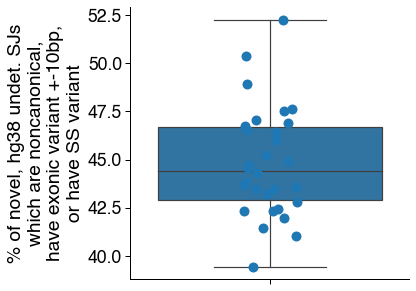

In [43]:
init_plot_settings(aspect='square')
temp = temp.loc[temp.has_explanation==True]
ax  = sns.boxplot(temp, 
                  y='perc', showfliers=False)
sns.stripplot(temp,
              y='perc',
              size=10)
ax.set(ylabel='% of novel, hg38 undet. SJs\nwhich are noncanonical,\nhave exonic variant +-10bp,\nor have SS variant')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [44]:
temp.perc.median()

44.4328359654134

In [45]:
temp.n_sj.median()

205.5

In [46]:
temp.total.median()

465.0